These instructions the project has been configured correctly and all software was installed. 

1. If this file exists, delete it: `runs/my_avi_tscan_inference_cpu/my_avi_tscan_preprocessed/saved_test_outputs/PURE_TSCAN_UBFC-rPPG_outputs.pickle`
2. If this directory exists, delete it: `mkos/preprocessed_inference`
3. Copy your video as .avi here: `mkos/raw/subject1/vid.avi`. It has to be named `vid.avi`.
4. Run the below cell, to get the FS value. You will use it in the next step.

In [7]:
import cv2
import pathlib as pathlib
import math

def find_git_root(path=None):
    """Find the root of the git repository by searching for .git."""
    if path is None:
        path = pathlib.Path.cwd()
    for parent in [path] + list(path.parents):
        if (parent / ".git").exists():
            return parent
    raise FileNotFoundError("No .git directory found in any parent directories.")


repo_root = find_git_root()

data_out_path = repo_root / "runs/my_avi_tscan_inference_cpu/my_avi_tscan_preprocessed/saved_test_outputs/PURE_TSCAN_UBFC-rPPG_outputs.pickle"

video_path = repo_root / "mkos"/"raw"/"subject1"/"vid.avi"

cap = cv2.VideoCapture(str(video_path))

if not cap.isOpened():
    print("Error: Could not open video.")
else:
    print(f"File: {video_path}")
    print(f"Frame count: {int(cap.get(cv2.CAP_PROP_FRAME_COUNT))}")
    print(f"Frame width: {int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))}")
    print(f"Frame height: {int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))}")
    print(f"FPS: {cap.get(cv2.CAP_PROP_FPS):.2f}")
    print(f"Duration (s): {int(cap.get(cv2.CAP_PROP_FRAME_COUNT)) / cap.get(cv2.CAP_PROP_FPS):.2f}")
    print(f"Codec (fourcc): {int(cap.get(cv2.CAP_PROP_FOURCC))}")
    print()
    print(f"FS VALUE: {int(math.ceil(cap.get(cv2.CAP_PROP_FPS)))}")

cap.release()

File: /home/maciek/GitHub/rPPG-Toolbox/mkos/raw/subject1/vid.avi
Frame count: 2102
Frame width: 640
Frame height: 480
FPS: 28.67
Duration (s): 73.31
Codec (fourcc): 1987535218

FS VALUE: 29


5. Open `configs/infer_configs/mkos-test-PURE_UBFC-rPPG_TSCAN_BASIC.yaml` and change the value of `FS` to the one from above. 
6. Run the below cell.

In [9]:
!python main.py --config_file ./configs/infer_configs/mkos-test-PURE_UBFC-rPPG_TSCAN_BASIC.yaml

--- PyTorch multiprocessing start method set to 'spawn' ---
=> Merging a config file from ./configs/infer_configs/mkos-test-PURE_UBFC-rPPG_TSCAN_BASIC.yaml
Configuration:
BASE: ['']
DEVICE: cpu
INFERENCE:
  BATCH_SIZE: 1
  EVALUATION_METHOD: FFT
  EVALUATION_WINDOW:
    USE_SMALLER_WINDOW: True
    WINDOW_SIZE: 10
  MODEL_PATH: ./final_model_release/PURE_TSCAN.pth
LOG:
  PATH: runs/my_avi_tscan_inference_cpu
MODEL:
  BIGSMALL:
    FRAME_DEPTH: 3
  DROP_RATE: 0.0
  EFFICIENTPHYS:
    FRAME_DEPTH: 10
  FactorizePhys:
    CHANNELS: 3
    FRAME_NUM: 160
    MD_FSAM: False
    MD_INFERENCE: True
    MD_R: 1
    MD_RESIDUAL: True
    MD_S: 1
    MD_STEPS: 4
    MD_TRANSFORM: T_KAB
    MD_TYPE: NMF
    TYPE: Standard
  MODEL_DIR: runs/my_avi_tscan_inference_cpu/_SizeW128_SizeH128_ClipLength180_DataType_DataAugNone_LabelType_Crop_faceTrue_BackendHC_Large_boxTrue_Large_size1.5_Dyamic_DetFalse_det_len30_Median_face_boxFalse/PreTrainedModels
  NAME: Tscan
  PHYSFORMER:
    DIM: 96
    FF_DIM: 144

7. Run the below cell to compute HR from PPG and plot it.

Processing 'subject1': 11 chunks.
Sampling Frequency (fs): 29 Hz
Label Type: DiffNormalized, Diff Flag: True


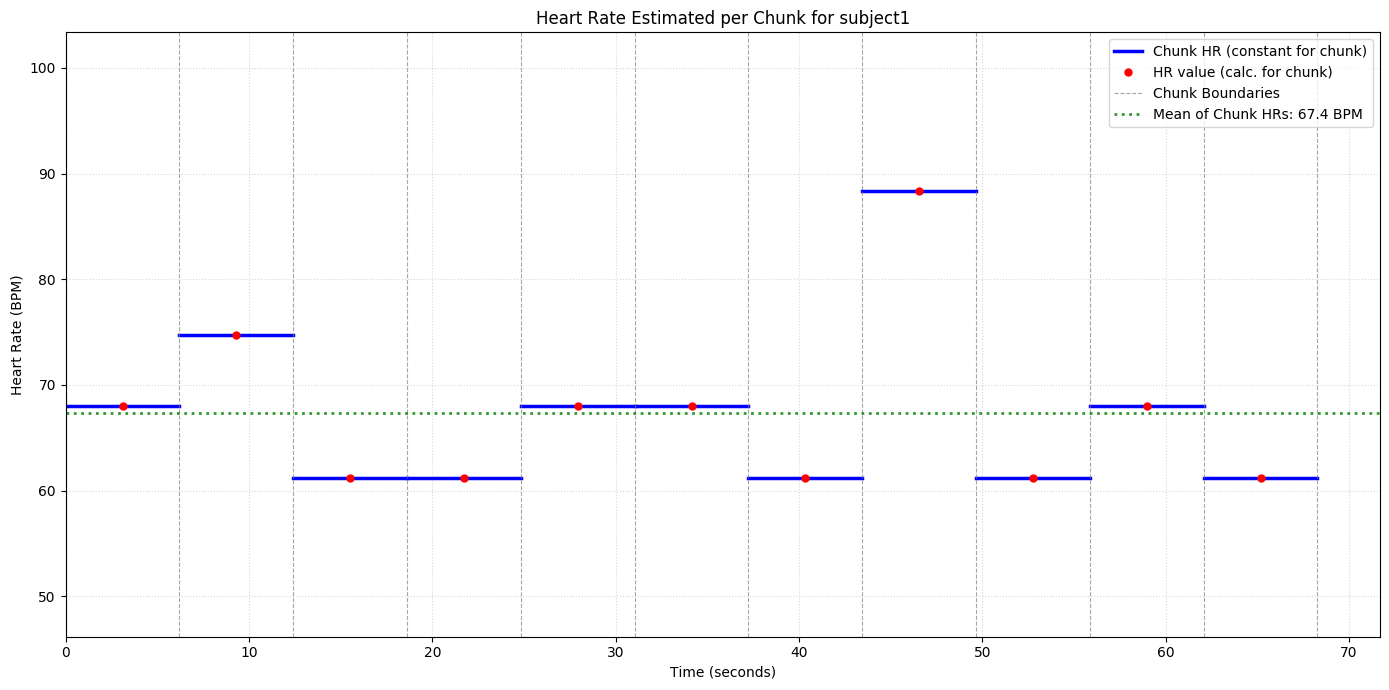

In [ ]:
# !pip install natsort opencv-python 
# !pip install scipy
# !pip install natsort
# !pip install ipywidgets

import cv2
import pickle
import numpy as np
import os
import sys
import matplotlib.pyplot as plt
import re

import torch

import numpy as np
# import ipywidgets as widgets
from IPython.display import display, clear_output
from natsort import natsorted
import os
import scipy
from scipy.sparse import spdiags
from scipy.signal import butter
import math
from scipy import linalg
from scipy import signal
from scipy import sparse

if str(repo_root) not in sys.path:
    sys.path.append(repo_root_path_str)

# HELPER FUNCTIONS

def _reform_data_from_dict(data, flatten=True):
    """Helper func for calculate metrics: reformat predictions and labels from dicts. """
    sort_data = sorted(data.items(), key=lambda x: x[0])
    sort_data = [i[1] for i in sort_data]
    sort_data = torch.cat(sort_data, dim=0)

    if flatten:
        sort_data = np.reshape(sort_data.cpu(), (-1))
    else:
        sort_data = np.array(sort_data.cpu())

    return sort_data

def _process_signal(signal, fs=30, diff_flag=True):
    # Detrend and filter
    use_bandpass = True
    if diff_flag:  # if the predictions and labels are 1st derivative of PPG signal.
        gt_bvp = _detrend(np.cumsum(signal), 100)
    else:
        gt_bvp = _detrend(signal, 100)
    if use_bandpass:
        # bandpass filter between [0.75, 2.5] Hz
        # equals [45, 150] beats per min
        [b, a] = butter(1, [0.75 / fs * 2, 2.5 / fs * 2], btype='bandpass')
        signal = scipy.signal.filtfilt(b, a, np.double(signal))
    return signal

def _detrend(input_signal, lambda_value):
    """Detrend PPG signal."""
    signal_length = input_signal.shape[0]
    # observation matrix
    H = np.identity(signal_length)
    ones = np.ones(signal_length)
    minus_twos = -2 * np.ones(signal_length)
    diags_data = np.array([ones, minus_twos, ones])
    diags_index = np.array([0, 1, 2])
    D = spdiags(diags_data, diags_index,
                (signal_length - 2), signal_length).toarray()
    detrended_signal = np.dot(
        (H - np.linalg.inv(H + (lambda_value ** 2) * np.dot(D.T, D))), input_signal)
    return detrended_signal

import pickle
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal
from scipy.signal import butter
import sys
import os



if str(repo_root) not in sys.path:
    sys.path.append(repo_root_path_str)

try:
    from evaluation.post_process import _detrend, _calculate_fft_hr
except ImportError:
    print("WARNING: Could not import _detrend and _calculate_fft_hr from evaluation.post_process.")
    print("Ensure rPPG-Toolbox is in sys.path or these functions are defined/imported elsewhere.")

def plot_heart_rate_per_chunk(
    pickle_file_path: str,
    subject_id: str = 'subject1',
    # target_hr_bpm_range: tuple = (40, 180), # todo mkos
    plot_reference_midpoints: bool = True,
    figsize: tuple = (14, 7)
) -> None:
    """Plots the heart rate (HR) estimated per video chunk over time.

    This function loads rPPG (remote Photoplethysmography) signal predictions
    from a specified .pickle file (typically an output from the rPPG-Toolbox),
    calculates the heart rate for each chunk of a given subject's data,
    and then plots these HR values as a step plot against time. The time
    axis is constructed from the actual duration of each chunk.

    The HR estimation involves:
    1.  Optional integration of differential signals.
    2.  Signal detrending using a smoothness priors approach.
    3.  Bandpass filtering to isolate physiological frequencies.
    4.  Fast Fourier Transform (FFT) to find the dominant frequency, which is
        then converted to Beats Per Minute (BPM).

    Args:
        pickle_file_path (str): The absolute or relative path to the .pickle
            file containing the model's output predictions and metadata.
            This file is expected to have a dictionary structure including
            'predictions' (a dict of subjects, each with a dict of chunks),
            'fs' (sampling frequency), and optionally 'label_type'.
        subject_id (str, optional): The identifier for the subject whose data
            is to be plotted. Defaults to 'subject1'.

        plot_reference_midpoints (bool, optional): If True, small circular
            markers will be plotted at the temporal midpoint of each chunk,
            indicating the point in time the HR value can be conceptually
            associated with. Defaults to True.
        figsize (tuple, optional): The (width, height) in inches for the
            matplotlib figure. Defaults to (14, 7).

        # todo mkos
        target_hr_bpm_range (tuple, optional): A tuple (min_bpm, max_bpm)
            defining the plausible physiological range for heart rates. This
            is used by the internal `_calculate_fft_hr` for peak picking.
            Defaults to (40, 180) BPM, which corresponds to 0.667 Hz to 3 Hz.
            Note: The internal `_calculate_fft_hr` uses hardcoded 0.75Hz to 4Hz.
            This argument is more of a conceptual pass-through if `_calculate_fft_hr`
            were to be made more flexible or if an alternative HR calculator is used.
            The bandpass filter applied *before* `_calculate_fft_hr` in this
            function uses 0.75 Hz to 2.5 Hz.

    Raises:
        FileNotFoundError: If the `pickle_file_path` does not exist.
        KeyError: If essential keys ('predictions', subject_id, 'fs') are
            missing from the loaded pickle file.
        ImportError: If `_detrend` or `_calculate_fft_hr` cannot be imported
            (may indicate issues with `sys.path` or rPPG-Toolbox structure).

    Returns:
        None: This function displays a matplotlib plot and does not return
        any value.

    Mathematical Outline of HR Estimation per Chunk:
    1.  **Signal Loading**:
        `s_raw[n]` = Raw signal samples for the current chunk.
        `L` = Length of `s_raw[n]`.
        `fs` = Sampling frequency.
        Duration of chunk = `L / fs`.

    2.  **Differential to Absolute (if applicable)**:
        If `label_type` indicates a differential signal (e.g., 'DiffNormalized'),
        the signal is integrated:
        `s_integrated[n] = cumsum(s_raw[n])`. This becomes the input for detrending.
        Otherwise, `s_integrated[n] = s_raw[n]`.

    3.  **Detrending (`_detrend`)**:
        Aims to remove low-frequency baseline wander. Based on smoothness priors
        (Tarvainen et al., 2002). It solves:
        `s_detrended = argmin_x { ||s_integrated - x||^2_2 + lambda^2 * ||D2*x||^2_2 }`
        where `D2` is a second-order difference matrix, and `lambda` (typically 100)
        controls the smoothness of the removed trend. `s_detrended` is the
        output.

    4.  **Bandpass Filtering**:
        A Butterworth bandpass filter is applied to `s_detrended` to isolate
        frequencies typically associated with heart rate. Common rPPG bands are
        around 0.75 Hz to 4 Hz. This function uses 0.75 Hz to 2.5 Hz.
        `[b, a] = butter(order=1, Wn=[f_low, f_high]/(fs/2), btype='bandpass')`
        `s_filtered[n] = filtfilt(b, a, s_detrended[n])`

    5.  **FFT for Dominant Frequency (`_calculate_fft_hr`)**:
        The Power Spectral Density (PSD) of `s_filtered[n]` is estimated using FFT
        (often via Welch's periodogram or a simple periodogram).
        `P[f] = |FFT(s_filtered[n])|^2`
        The dominant frequency `f_dom` is found by identifying the peak in `P[f]`
        within a physiologically plausible heart rate frequency range (e.g.,
        the 0.75 Hz to 4 Hz used internally by `_calculate_fft_hr`, although
        the bandpass here is 0.75-2.5Hz).

    6.  **Heart Rate Conversion**:
        `HR_bpm = f_dom * 60`
    """
    if not os.path.exists(pickle_file_path):
        raise FileNotFoundError(f"Pickle file not found at: {pickle_file_path}")

    try:
        with open(pickle_file_path, 'rb') as f:
            results = pickle.load(f)
    except Exception as e:
        print(f"Error loading pickle file: {e}")
        return

    # Validate essential keys
    if 'predictions' not in results:
        raise KeyError("'predictions' key not found in the pickle file.")
    if subject_id not in results['predictions']:
        available_subjects = list(results['predictions'].keys())
        raise KeyError(
            f"Subject '{subject_id}' not found in 'predictions'. "
            f"Available subjects: {available_subjects}"
        )
    if 'fs' not in results:
        raise KeyError("'fs' (sampling frequency) not found in the pickle file.")

    subject_preds_chunks_dict = results['predictions'][subject_id]
    fs = results['fs']
    label_type = results.get('label_type', 'DiffNormalized') # Default if not in pickle
    diff_flag = (label_type == 'DiffNormalized')

    num_chunks = len(subject_preds_chunks_dict)
    if num_chunks == 0:
        print(f"No chunks found for subject '{subject_id}'. Cannot plot.")
        return

    print(f"Processing '{subject_id}': {num_chunks} chunks.")
    print(f"Sampling Frequency (fs): {fs} Hz")
    print(f"Label Type: {label_type}, Diff Flag: {diff_flag}")

    chunk_hrs_pred = []
    chunk_start_times = []
    chunk_actual_durations = []
    cumulative_time = 0.0

    sorted_chunk_indices = sorted(subject_preds_chunks_dict.keys())

    for chunk_idx in sorted_chunk_indices:
        pred_chunk_tensor = subject_preds_chunks_dict[chunk_idx]

        if hasattr(pred_chunk_tensor, 'cpu'):
            pred_chunk_np = pred_chunk_tensor.cpu().numpy().flatten()
        elif hasattr(pred_chunk_tensor, 'numpy'):
            pred_chunk_np = pred_chunk_tensor.numpy().flatten()
        else:
            pred_chunk_np = np.array(pred_chunk_tensor).flatten()

        actual_chunk_len_frames = len(pred_chunk_np)
        actual_chunk_duration_seconds = actual_chunk_len_frames / fs
        
        chunk_start_times.append(cumulative_time)
        chunk_actual_durations.append(actual_chunk_duration_seconds)

        processed_signal = pred_chunk_np
        if diff_flag:
            processed_signal = np.cumsum(processed_signal)

        hr_p_current_chunk = np.nan # Default to NaN if skipped
        # Check length for detrend (needs at least 3 for D matrix in _detrend)
        if len(processed_signal) < 3 :
            print(f"  Skipping chunk {chunk_idx} (length {len(processed_signal)}) for detrending.")
        # Check length for filter (1st order Butterworth, padlen is 3*max(len(a),len(b)) = 3*2 = 6)
        elif len(processed_signal) <= 6 :
            print(f"  Skipping chunk {chunk_idx} (length {len(processed_signal)}) for filtering.")
        else:
            try:
                processed_signal_detrended = _detrend(processed_signal, 100)
                
                # Bandpass filter settings (consistent with prior successful cells)
                # Note: _calculate_fft_hr might have its own internal range for peak picking.
                # This bandpass is a pre-filter.
                low_cutoff_hz, high_cutoff_hz = 0.75, 2.5 
                [b_bp, a_bp] = butter(1, [low_cutoff_hz / (fs / 2), high_cutoff_hz / (fs / 2)], btype='bandpass')
                processed_signal_filtered = scipy.signal.filtfilt(b_bp, a_bp, np.double(processed_signal_detrended))
                
                hr_p_current_chunk = _calculate_fft_hr(processed_signal_filtered, fs=fs)
            except Exception as e_process:
                print(f"  Error processing chunk {chunk_idx}: {e_process}")
                hr_p_current_chunk = np.nan # Ensure it's NaN on error
        
        chunk_hrs_pred.append(hr_p_current_chunk)
        cumulative_time += actual_chunk_duration_seconds
    
    chunk_end_of_last_segment = cumulative_time

    # --- Plotting ---
    if not chunk_hrs_pred:
        print("No heart rates were calculated (all chunks may have been skipped). Cannot plot.")
        return

    fig, ax1 = plt.subplots(figsize=figsize)
    
    valid_segments_count = 0
    for i in range(len(chunk_hrs_pred)):
        if not np.isnan(chunk_hrs_pred[i]):
            current_chunk_start_time = chunk_start_times[i]
            # End time for this segment is the start of the next, or total end time
            next_segment_start_time = chunk_start_times[i+1] if (i + 1) < len(chunk_start_times) else chunk_end_of_last_segment
            
            ax1.plot([current_chunk_start_time, next_segment_start_time],
                     [chunk_hrs_pred[i], chunk_hrs_pred[i]],
                     color='blue', linewidth=2.5,
                     label='Chunk segment' if valid_segments_count == 0 else None)
            valid_segments_count +=1

    if valid_segments_count == 0:
        print("All calculated HRs are NaN. Cannot plot meaningful HR segments.")
    else:
        if plot_reference_midpoints:
            mid_points_x = [st + dur/2 for st, dur, hr in zip(chunk_start_times, chunk_actual_durations, chunk_hrs_pred) if not np.isnan(hr)]
            mid_points_y = [hr for hr in chunk_hrs_pred if not np.isnan(hr)]
            if mid_points_x: # Check if there are any valid midpoints
                ax1.plot(mid_points_x, mid_points_y, 'o', color='red', markersize=5,
                         label='HR value (calc. for chunk)')

        # Add vertical lines for actual chunk boundaries
        boundary_label_done = False
        for t_start_boundary in chunk_start_times:
            ax1.axvline(x=t_start_boundary, color='gray', linestyle='--', linewidth=0.8, alpha=0.7, 
                        label='Chunk Boundaries' if not boundary_label_done else None)
            boundary_label_done = True
        if chunk_start_times: # Ensure list isn't empty
            ax1.axvline(x=chunk_end_of_last_segment, color='gray', linestyle='--', linewidth=0.8, alpha=0.7)

        mean_hr_pred = np.nanmean(chunk_hrs_pred)
        ax1.axhline(y=mean_hr_pred, color='green', linestyle=':', linewidth=2, alpha=0.8,
                    label=f'Mean of Chunk HRs: {mean_hr_pred:.1f} BPM')

        ax1.set_xlabel('Time (seconds)')
        ax1.set_ylabel('Heart Rate (BPM)')
        ax1.set_title(f'Heart Rate Estimated per Chunk for {subject_id}')
        ax1.legend(loc='upper right')
        ax1.grid(True, linestyle=':', alpha=0.5)

        non_nan_hrs = [hr for hr in chunk_hrs_pred if not np.isnan(hr)]
        if non_nan_hrs:
            min_hr_val, max_hr_val = min(non_nan_hrs), max(non_nan_hrs)
            ax1.set_ylim(max(0, min_hr_val - 15), max_hr_val + 15) # Increased padding for y-axis
        
        if chunk_start_times:
            plot_end_time = chunk_end_of_last_segment
            ax1.set_xlim(0, plot_end_time + plot_end_time * 0.05 if plot_end_time > 0 else 10)
        else: # Handle case where chunk_start_times might be empty if all chunks are bad
            ax1.set_xlim(0, 10)


    plt.tight_layout()
    plt.show()

if 'data_out_path' in locals() or 'data_out_path' in globals():
    try:
        plot_heart_rate_per_chunk(data_out_path, subject_id='subject1')
    except Exception as e:
        print(f"Error during example usage: {e}")
else:
    print("Skipping example usage: 'data_out_path' not defined.")


